# evoke Tutorial

## Basics: Using results from the literature

### Creating figures; tweaking cosmetic features

Suppose you want to recreate Figure 1.1 from page 11 of *Signals* (Skyrms 2010).
It's as easy as importing the relevant class and creating an instance of it.

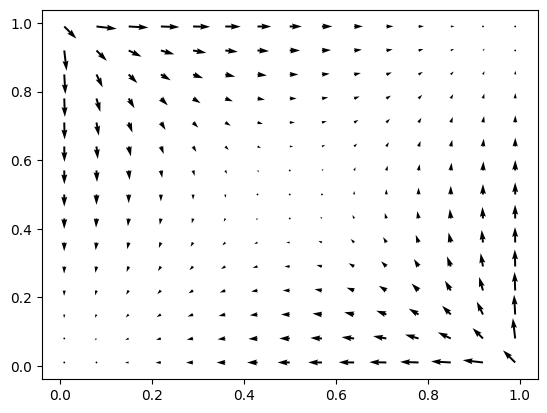

In [ ]:
# Ensure evoke is installed
#!pip install evoke-signals # Uncomment when package exists on PyPI

# Import the class
from evoke.examples.skyrms2010signals import Skyrms2010_1_1

# Create an instance of the class
fig1_1 = Skyrms2010_1_1()

Let's say you don't like the boring black arrows and want them to be blue instead.
The figure you just created has various customisable options.
Change the `color` attribute, and evoke will automatically rebuild the plot:

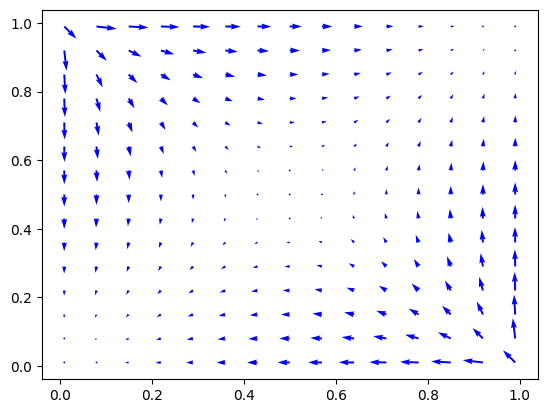

In [ ]:
fig1_1.color = "blue"

Now suppose you're appalled at the lack of axis labels.
You can add them like standard class attributes.
The figure will again be instantly recreated.

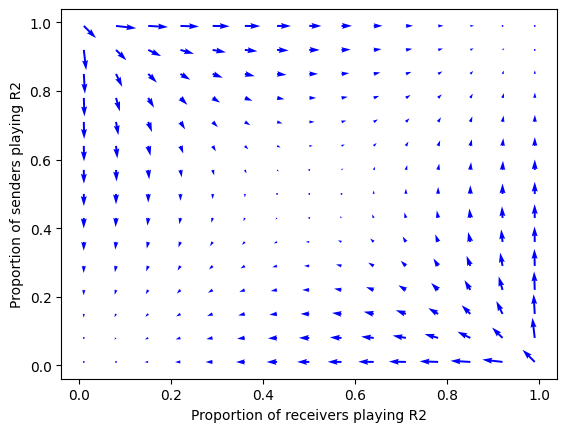

In [ ]:
fig1_1.show_immediately = False # Let's not create two new plots...
fig1_1.xlabel = "Proportion of receivers playing R2"
fig1_1.ylabel = "Proportion of senders playing R2"
fig1_1.show() #... let's just create one manually.

Here we suppressed the immediate output upon changing an attribute by first setting `fig1_1.show_immediately = False`.
Without this, the code would have created two new figures, one after the setting of `fig1_1.xlabel` and one after `fig1_1.ylabel`.

Some figures look better without axes at all.
Skyrms' second figure is an example:

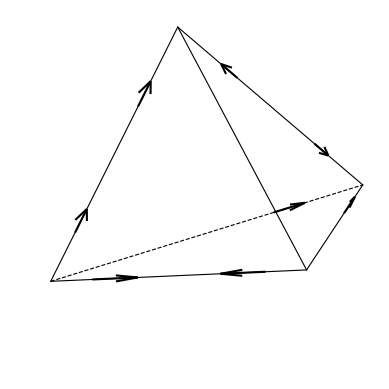

In [ ]:
from evoke.examples.skyrms2010signals import * # import all figures from Skyrms

fig1_2 = Skyrms2010_1_2() # Create figure 1.2

If you want to see the axes, just switch `noaxis` to `False`:

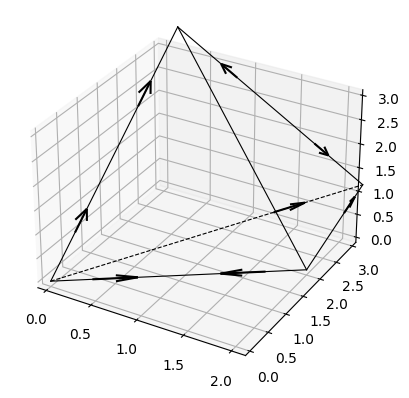

In [ ]:
fig1_2.noaxis = False

I know what you're thinking, and the answer is yes, you can make the arrows blue.

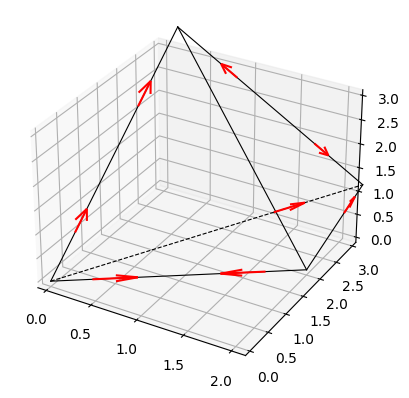

In [ ]:
fig1_2.color = "red"

### Changing data in figures

One of the useful features of evoke is that it allows you to re-run existing figures with different data.
In this way you can see how the results of a simulation would change if the parameters were tweaked.

Let's take figure 3.3 of Skyrms(2010:40) as an example.
Once again we can create the basic figure just by creating an instance of the object.

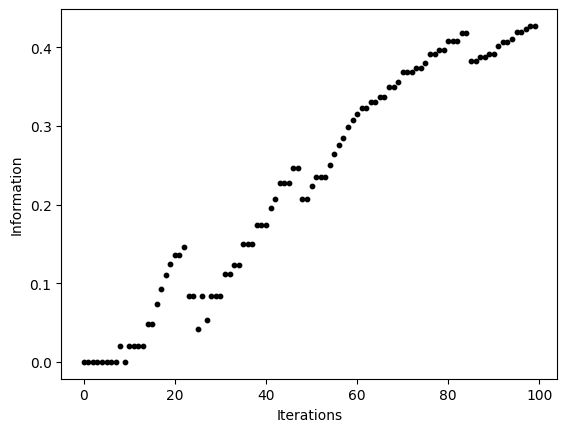

In [ ]:
fig3_3 = Skyrms2010_3_3()

(Figures like this rely on randomisation, so the figure above might look a little different from how it does in the book.)

The basic figure shows what happens after 100 iterations.
Let's say we want to see what happens after 1000:

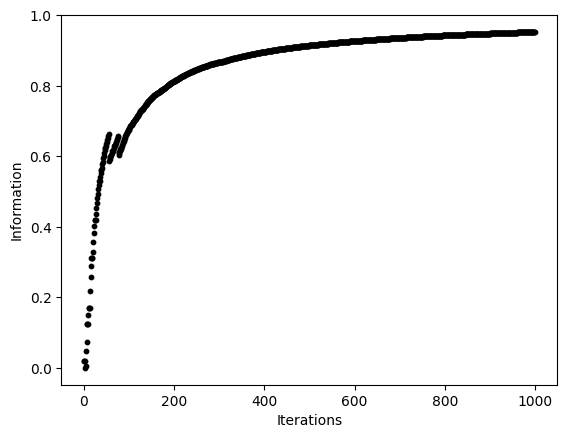

In [ ]:
fig3_3 = Skyrms2010_3_3(iterations=1000)

Even if 100 iterations was not enough to generate appreciable information transmission between agents, 1000 iterations very likely will be.

## Advanced: Creating your own results

### Defining game parameters

You can use evoke to create your own signalling games and evolutionary simulations.
Let's create a very simple 3x3 signalling game with two players.
We need four pieces of information to create the game:

+ `state_chances`: The number of states the sender can observe, and their probabilities. For this example there will be three equiprobable states.
+ `sender_payoff_matrix` and `receiver_payoff_matrix`: Matrices defining the payoffs of sender and receiver. For this example they will be the same: when the state matches the act, both agents get a payoff of 1, otherwise they get a payoff of zero.
+ `messages`: The number of messages available for the sender to send, which in this example is three.

In [ ]:
state_chances = np.array([1/3, 1/3, 1/3])
sender_payoff_matrix = np.eye(3)
receiver_payoff_matrix = np.eye(3)
messages = 3

Let's have a look at one of those payoff matrices:

In [ ]:
sender_payoff_matrix

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

The rows correspond to states and the columns to acts.
So when the first act is performed in the first state, the agent gets a payoff of 1, and ditto for the second and third states and acts.
Any other combination of state and act yields a payoff of zero.

### Creating the game object

Sender-receiver games are **asymmetric**, in that the sender and receiver have different roles.
They also have a state that is determined by chance.
We therefore need to import the `Chance` class from the `asymmetric_games` module.

In [ ]:
from evoke.lib.asymmetric_games import Chance

We can now create the game object,
This is an instance of the `Chance` class, with the game parameters fed into it.

In [ ]:
game = asy.Chance(
    state_chances   = state_chances,
    sender_payoff_matrix = sender_payoff_matrix,
    receiver_payoff_matrix = receiver_payoff_matrix,
    messages = messages
)

### Creating the simulation object

A game is a static object.
It doesn't do anything on its own.
To make something happen, we need a set of **strategies** and a means by which those strategies **evolve** according to the payoffs they bring to the agents.

Fortunately, the game object already knows all the strategies that are in principle available to an agent:

In [ ]:
sender_strategies = game.sender_pure_strats()
receiver_strategies = game.receiver_pure_strats()

Let's imagine that some senders always send the same signal no matter the state, while others choose a different signal for each state.
These correspond to the first and sixth sender strategies (indexed by 0 and 5, because python indexing starts from 0):

In [ ]:
sender_strategies[0] # Pure strategy 0: always send signal 1.

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [ ]:
sender_strategies[5] # Pure strategy 5: for all i, send signal i in state i.

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

So, we will construct a population with just these two strategies, along with the corresponding strategies for the receiver:

In [ ]:
sender_population = np.array(
    [sender_strategies[0],sender_strategies[5]] # An array of strategies i.e. an array of matrices!
)

receiver_population = np.array(
    [receiver_strategies[0],receiver_strategies[5]] # An array of strategies i.e. an array of matrices!
)

...and we can evolve a population playing some mixture of these strategies using an appropriate simulation object from the `evolve` module:

In [ ]:
from evoke.lib.evolve import TwoPops # One population of senders, one population of receivers

# Create the simulation object
evo = TwoPops(game, sender_population, receiver_population)

Let's see what happens when we evolve these populations.

In [ ]:
# Define equiprobable strategies
sender_strategy_vector = receiver_strategy_vector = np.array([1/2,1/2])

# Get a population vector in the format evo expects it
population_vector = np.concatenate((sender_strategy_vector, receiver_strategy_vector))

# For 100 iterations, get the new population vector
population_vectors_over_time = np.array([population_vector]) # this will store information about how the population changes
for _ in range(100):

    # Get the population vector at the next step
    population_vector = evo.discrete_replicator_delta_X(population_vector)

    # Store the population vector
    population_vectors_over_time = np.vstack((population_vectors_over_time,np.array([population_vector])))

Now `population_vectors_over_time` is a big list of how many of each type of sender and receiver there was at each step of the simulation.
Let's plot the change in the two sender types:

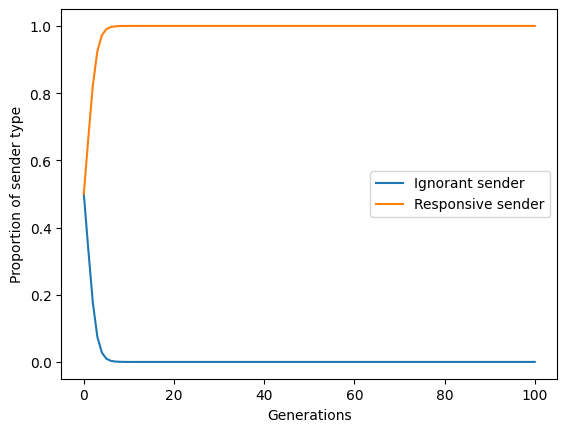

In [ ]:
from matplotlib import pyplot as plt

# Get the proportions of each sender type as it changes over time
sender_type_ignorant_time_series = population_vectors_over_time.T[0]
sender_type_responsive_time_series = population_vectors_over_time.T[1]

# Create the plot
plt.plot(range(len(population_vectors_over_time)),sender_type_ignorant_time_series,label="Ignorant sender")
plt.plot(range(len(population_vectors_over_time)),sender_type_responsive_time_series,label="Responsive sender")

# Add a legend
plt.legend()

# Add axis labels
plt.xlabel("Generations")
plt.ylabel("Proportion of sender type")

# Show the plot
plt.show()

The ignorant sender very quickly drops to zero, while the responsive sender very quickly dominates.

## Expert: Adding to the stock of figures

You might want to add figures from the literature that aren't part of evoke's example library yet.
If so, thanks!
We hope to expand the set of examples so that evoke can become a place to test modelling assumptions and play around with data.

### Fork the repository

First, fork the [evoke](https://github.com/signalling-games-org/evoke) repository.

### Create a script

To add an example, create a new script whose name is the same format as the others in the `evoke/examples/` directory i.e. the first author's surname, the year, and the first word of the publication's title, all in lower case and without breaks or punctuation.
So for example Skyrms's book *Signals*, published in 2010, becomes `skyrms2010signals.py`.
The paper 'Communication and Common Interest' by Godfrey-Smith and Martínez becomes `godfreysmith2013communication.py`.

### Subclass from `figure.py`

Inside your script, create an object with the name formatted `Surname_Year_figure_number`.
For example, figure 4.1 of Skyrms (2010) is called `Skyrms_2010_4_1`.

This object **must** subclass from one of the classes defined in `figure.py`.

### Add custom code

Add your custom code in the object you just created.
Take a look at the existing examples to get a feel for how this works.

### Pull request

When you've tested and everything looks good, create a pull request from your fork.